In [37]:
import numpy as np
import pandas as pd
import plotly.express as px
from matplotlib import pyplot as plt
import scipy.stats as sts
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df = pd.read_excel("BakeryData_Vilnius.xlsx")
#stores = ["main street A","main street B","station A","station B"]

daysOfTheWeek = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["weekday"] = df['date'].dt.strftime('%A')
df["date"] = pd.to_datetime(df["date"])
df.set_index('date', inplace=True)

In [38]:
begin = datetime(day = 31,month = 12,year = 2016)
pre_covid = datetime(day = 1,month = 3,year = 2021)
after_covid = datetime(day = 1,month = 3,year = 2022)
df = df[(df.index > after_covid)]

def removeOutliers(df):
    mean = df.mean()
    sd = df.std()
    return df[(df > (mean - 3*sd)) & (df < (mean + 3*sd))]

Store we are currenly trying to optimise.

In [39]:
store = "station A"
p, p_L, c, c_s = 4.64, 0.15, 4.16, 0.08

numberOfDataPoints = len(df)
verificationPrediction = int(numberOfDataPoints / 2)
futurePrediction = 30 #days

In [40]:
def adf_test(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"{key}: {value}")
    
adf_test(df[store].dropna())

ADF Statistic: -6.0270970368345615
p-value: 1.4471999005501903e-07
Critical Values:
1%: -3.4454029241336483
5%: -2.8681766097362087
10%: -2.570305075326362


Here we setup the ARIMA model, we will use roughly half of the data (250 points) to estimate the distribution.

In [41]:
train = df.iloc[:-(1+verificationPrediction)]
test = df.iloc[-(1+verificationPrediction):]

model = ARIMA(train[store], order=(30,1,30))
model = model.fit()

c:\Users\Marijn Korthouwer\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Marijn Korthouwer\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Marijn Korthouwer\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Marijn Korthouwer\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary st

c:\Users\Marijn Korthouwer\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Here we decide on the future prediction and do some dataframe work so everything will fit in properly.

In [42]:
empty_data = {store: [None] * futurePrediction}

empty_df = pd.DataFrame(empty_data)

# set date to last date in dataset
new_index = pd.date_range('2023-05-31', periods=futurePrediction, freq='D')
empty_df.index = new_index
df = pd.concat([df, empty_df])
df["weekday"] = df.index.dayofweek
df["weekday"] = df.index.strftime('%A')

In [43]:
# Setup prediction dataset
start = len(train)
end = len(train) + len(test) + futurePrediction
df["predicted"] = model.predict(start=start,end=end, typ='levels')

c:\Users\Marijn Korthouwer\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


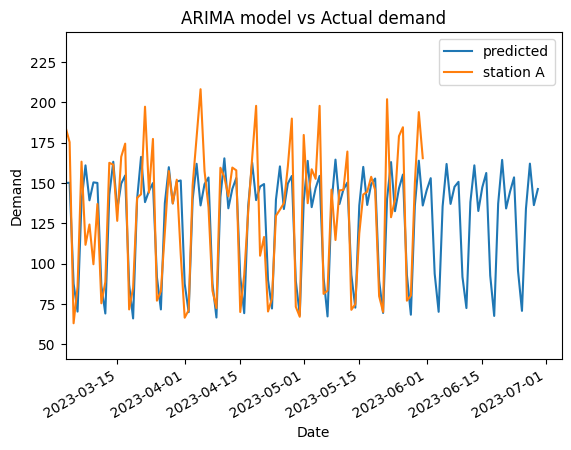

In [57]:
df["predicted"].plot()
df[store].plot()
# Set x-axis limits
start_date = "2023-03-02"  # Specify the start date
end_date = "2023-07-05"    # Specify the end date
plt.xlim(start_date, end_date)
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.title("ARIMA model vs Actual demand")
#plt.savefig("Excercise part BONUS/ARIMA.pdf")
plt.show()

In [45]:
# find ratio between predictions and real values and scale predicted values to a distribtion.
df["fd_ratio"] = df[store] / df["predicted"]
fd_average = df["fd_ratio"].mean()
df_std = df["fd_ratio"].std()

df['mean'] = fd_average * df['predicted']
df['std'] = df_std * df['predicted']
print("The mean error of the model is {0} and the standard deviation is {1}".format(fd_average, df_std))

The mean error of the model is 1.0216270914981516 and the standard deviation is 0.1959626990203063


In [46]:
def calculateOptimalOrderQuantity(row, p,p_L,c,c_s):
    overage_cost = p - c
    underage_cost = c + c_s - p_L
    quantile = overage_cost / ( overage_cost + underage_cost)
    optimalQuantity = sts.norm.ppf(quantile, loc=row["mean"], scale=row["std"])
    return optimalQuantity

df['order quantity'] = df.apply(calculateOptimalOrderQuantity,axis=1,args=(p,p_L,c,c_s))

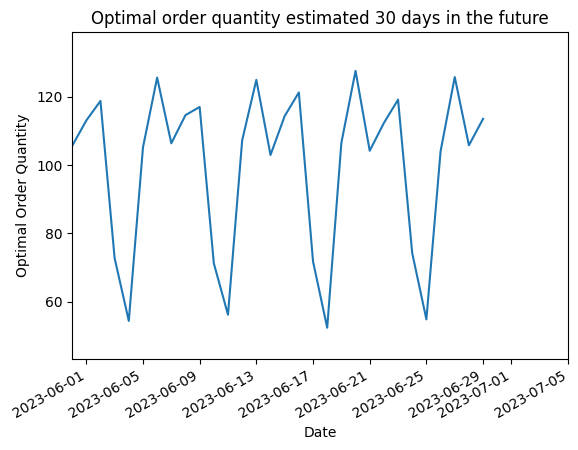

In [58]:
df["order quantity"].plot()
# Set x-axis limits
start_date = "2023-05-31"  # Specify the start date
end_date = "2023-07-05"    # Specify the end date
plt.xlim(start_date, end_date)
plt.xlabel("Date")
plt.ylabel("Optimal Order Quantity")
plt.title("Optimal order quantity estimated 30 days in the future")
#plt.savefig("Excercise part BONUS/ARIMA-forecast.pdf")
plt.show()

In [48]:
df[df.index > "2023-05-31"]

,weekday,main street A,main street B,station A,station B,predicted,fd_ratio,mean,std,order quantity
2023-06-01,Thursday,NaN,NaN,NaN,NaN,145.644267,NaN,148.794128,28.540844,113.021465
2023-06-02,Friday,NaN,NaN,NaN,NaN,153.027898,NaN,156.337446,29.987760,118.751239
2023-06-03,Saturday,NaN,NaN,NaN,NaN,93.721457,NaN,95.748379,18.365910,72.728825
2023-06-04,Sunday,NaN,NaN,NaN,NaN,70.069804,NaN,71.585210,13.731068,54.374896
2023-06-05,Monday,NaN,NaN,NaN,NaN,135.480665,NaN,138.410718,26.549157,105.134405
2023-06-06,Tuesday,NaN,NaN,NaN,NaN,161.832969,NaN,165.332946,31.713225,125.584066
2023-06-07,Wednesday,NaN,NaN,NaN,NaN,137.047880,NaN,140.011827,26.856272,106.350579
2023-06-08,Thursday,NaN,NaN,NaN,NaN,147.679121,NaN,150.872991,28.939599,114.600533
2023-06-09,Friday,NaN,NaN,NaN,NaN,150.746374,NaN,154.006580,29.540666,116.980753
2023-06-10,Saturday,NaN,NaN,NaN,NaN,91.776768,NaN,93.761633,17.984823,71.219726
